In [2]:
import pandas as pd 
import pyodbc 
import numpy as np
import os

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:


# Définir le chemin vers le dossier DATA
data_path = Path.cwd() / 'DATA'

# Charger les fichiers CSV
data = pd.read_csv(
    data_path / 'data.csv',
    dtype={
        "NoClient": str,
        "composite_key": str
    }
)


# Aperçu des fichiers
print("Aperçu de data :")
print(data.head())





--- Médianes des temps par catégorie NAF ---
                    temps_code1  temps_code3  temps_code4  temps_code5  \
naf_cluster                                                              
Autres                   11.250        4.445         0.50        2.000   
Commerce de détail       21.500        9.210         1.88       15.630   
Restauration             20.825       10.565         1.70       21.075   
Santé et social          10.400        4.250         0.00        2.300   
Éducation                13.100        4.200         0.70        3.950   

                    temps_code6  
naf_cluster                      
Autres                     0.00  
Commerce de détail         5.45  
Restauration               6.41  
Santé et social            0.00  
Éducation                  0.00  


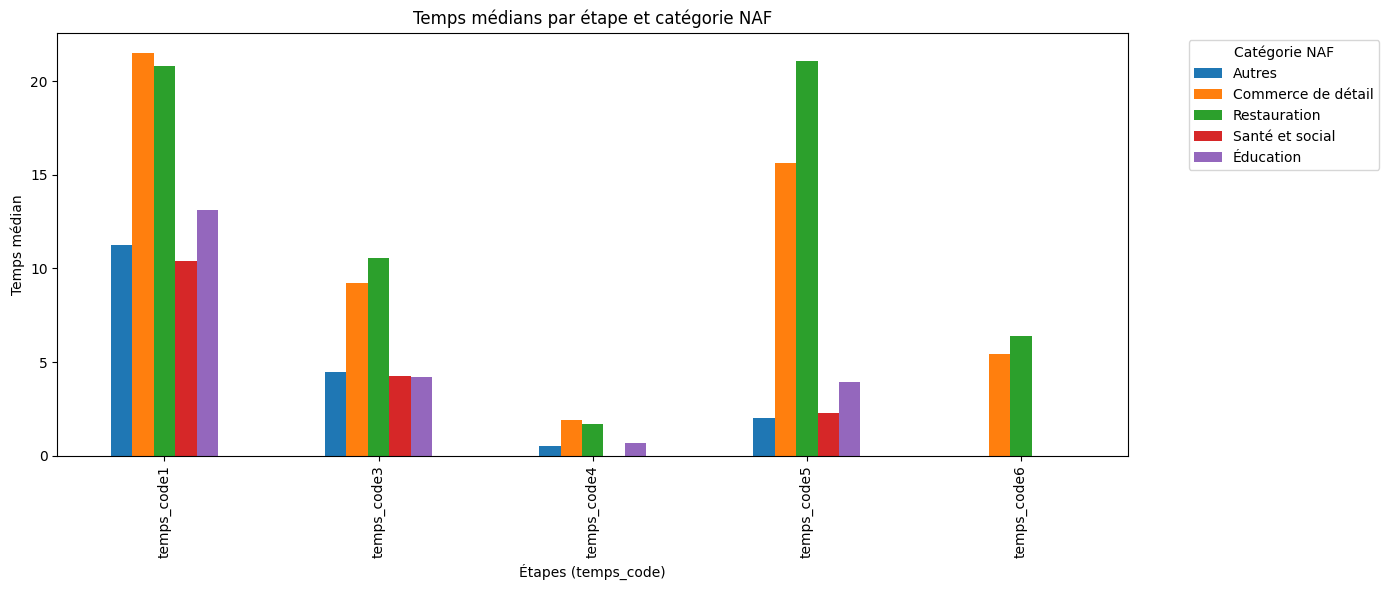

In [11]:
# Regrouper les codes NAF en catégories
def regrouper_code_naf(code):
    if pd.isnull(code):
        return 'NA'
    elif str(code).startswith('47'):
        return 'Commerce de détail'
    elif str(code).startswith('56'):
        return 'Restauration'
    elif str(code).startswith('85'):
        return 'Éducation'
    elif str(code).startswith('86') or str(code).startswith('87') or str(code).startswith('88'):
        return 'Santé et social'
    else:
        return 'Autres'

filtered['naf_cluster'] = filtered['code_naf'].apply(regrouper_code_naf)

# Médianes des temps par catégorie NAF
print("\n--- Médianes des temps par catégorie NAF ---")
print(filtered.groupby('naf_cluster')[temps_cols].median())


# Graphe
filtered.groupby('naf_cluster')[temps_cols].median().T.plot(kind='bar', figsize=(14, 6))
plt.title("Temps médians par étape et catégorie NAF")
plt.xlabel("Étapes (temps_code)")
plt.ylabel("Temps médian")
plt.legend(title="Catégorie NAF", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


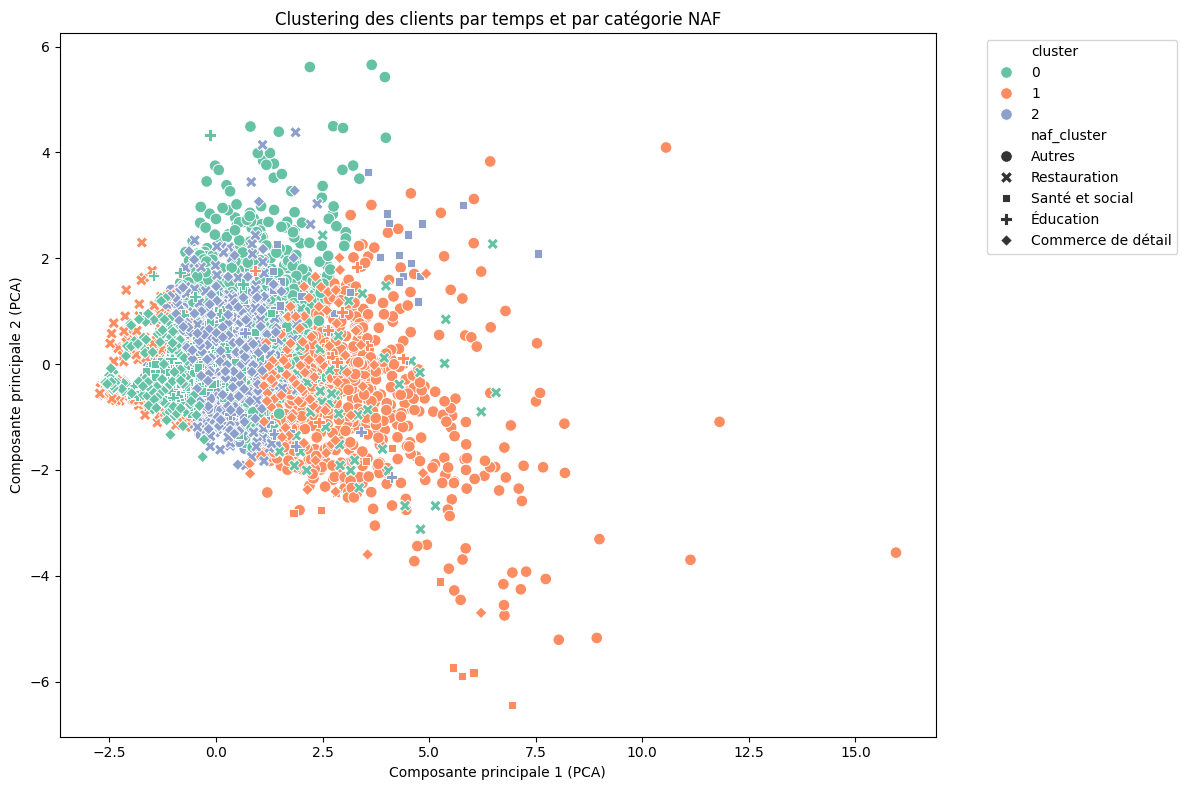


--- Temps médians par cluster et par catégorie NAF ---


Catégorie NAF : Autres
         temps_code1  temps_code3  temps_code4  temps_code5  temps_code6
cluster                                                                 
0             20.150         8.60        2.350         9.15        5.045
1             35.255        17.95        2.065        37.12       16.950
2              5.300         1.43        0.000         0.75        0.000


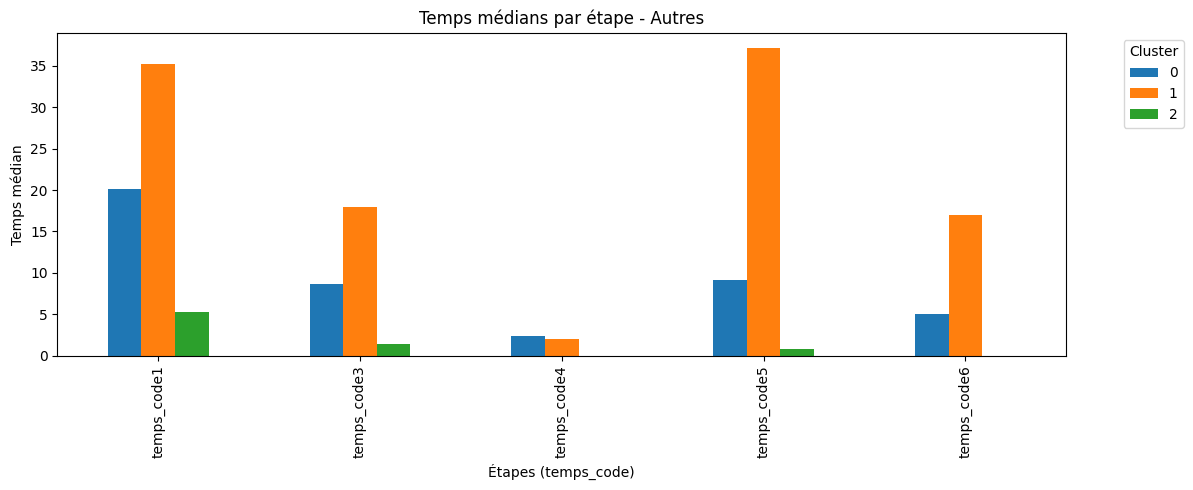


Catégorie NAF : Restauration
         temps_code1  temps_code3  temps_code4  temps_code5  temps_code6
cluster                                                                 
0             36.150        25.30         1.85       40.470        24.25
1              8.865         4.60         0.15        2.975         0.25
2             24.950        12.55         2.05       27.250         8.13


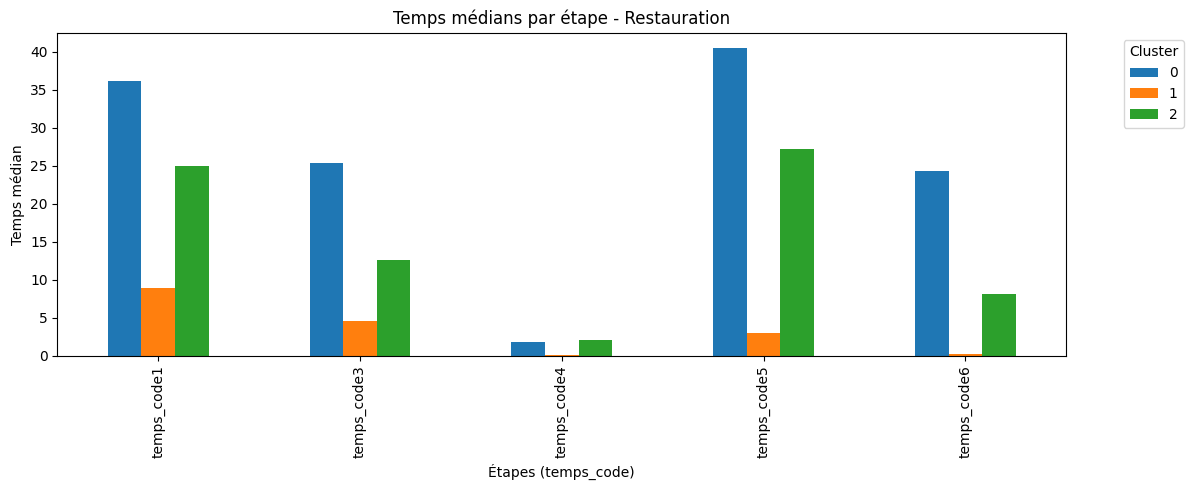


Catégorie NAF : Santé et social
         temps_code1  temps_code3  temps_code4  temps_code5  temps_code6
cluster                                                                 
0              9.750        3.650         0.00        2.250        0.000
1             51.725        7.375         0.00        0.185       85.465
2             21.850       10.475         2.36       17.775       15.645


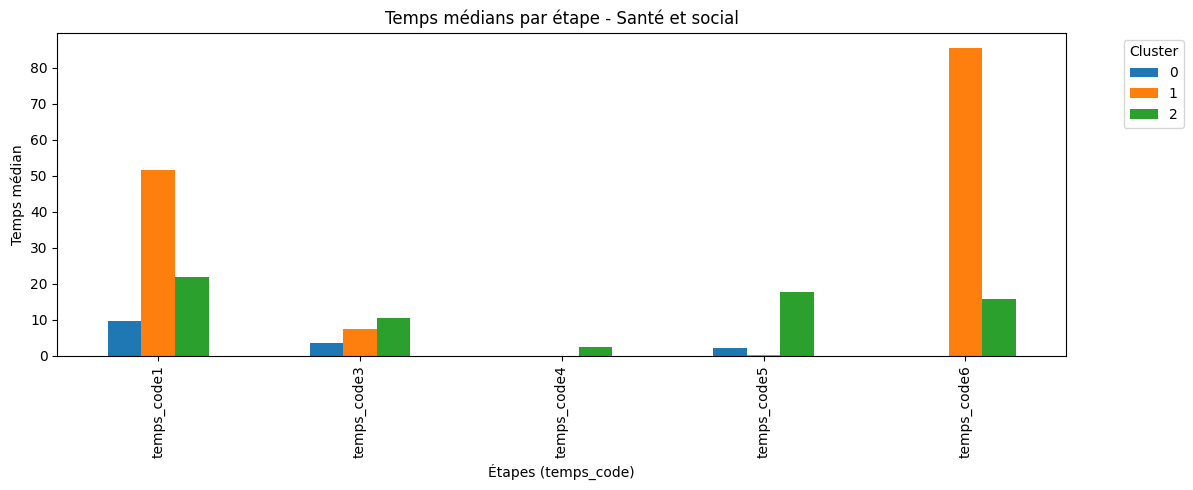


Catégorie NAF : Éducation
         temps_code1  temps_code3  temps_code4  temps_code5  temps_code6
cluster                                                                 
0              9.875         2.98         0.20        1.000        0.000
1             27.710        11.50         2.75       27.575        2.475
2             18.600        13.18         0.00       15.650        0.550


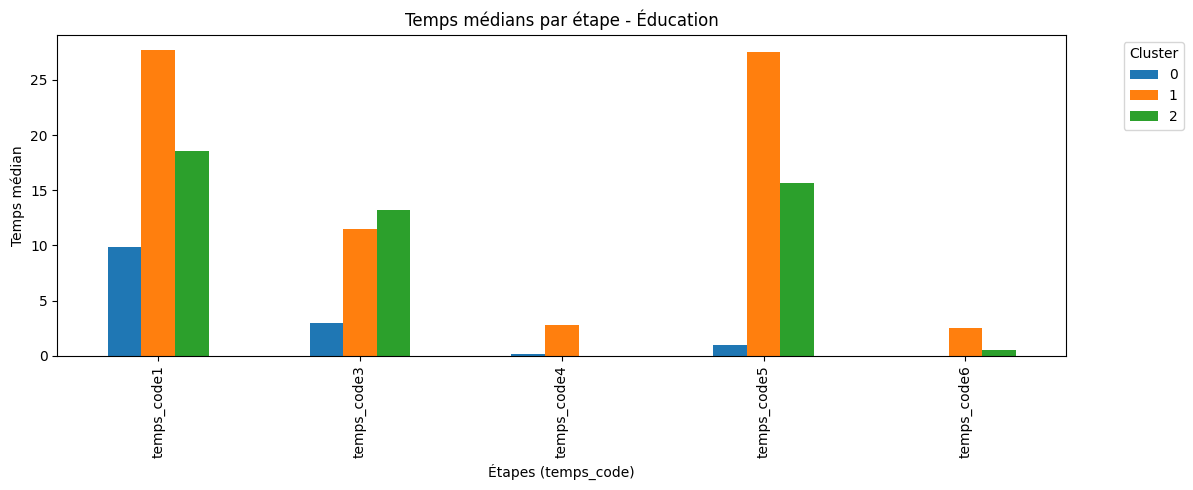


Catégorie NAF : Commerce de détail
         temps_code1  temps_code3  temps_code4  temps_code5  temps_code6
cluster                                                                 
0               9.70        3.670        0.000         1.00        0.025
1              37.80       19.500        2.500        43.20       12.530
2              24.03       10.865        2.295        20.95        6.225


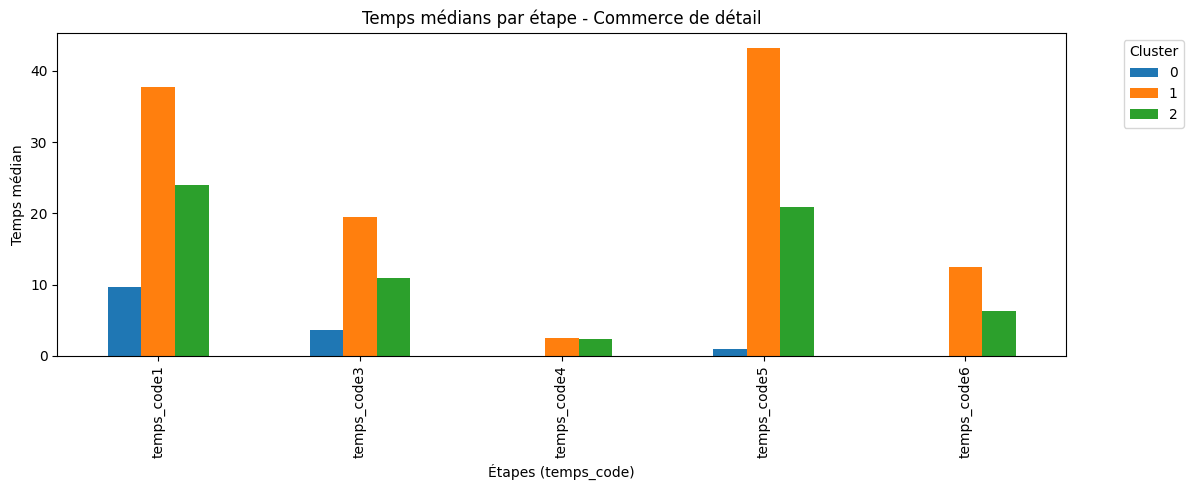

In [15]:
# Étape 1 — Sélection des colonnes de temps
temps_cols = [col for col in data.columns if col.startswith("temps_code")]

# Étape 2 — Regrouper les codes NAF en grandes catégories
def regrouper_code_naf(code):
    if pd.isnull(code):
        return 'NA'
    elif str(code).startswith('47'):
        return 'Commerce de détail'
    elif str(code).startswith('56'):
        return 'Restauration'
    elif str(code).startswith('85'):
        return 'Éducation'
    elif str(code).startswith(('86', '87', '88')):
        return 'Santé et social'
    else:
        return 'Autres'

data['naf_cluster'] = data['code_naf'].apply(regrouper_code_naf)

# Étape 3 — Filtrage des lignes avec au moins un temps > 0
data_filtered = data[data[temps_cols].gt(0).any(axis=1)].copy()

# Étape 4 — Appliquer le clustering pour chaque catégorie NAF séparément
results = []

for naf_cat in data_filtered['naf_cluster'].unique():
    subset = data_filtered[data_filtered['naf_cluster'] == naf_cat].copy()

    # Sauter les petits groupes
    if len(subset) < 10:
        continue

    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(subset[temps_cols])

    # Clustering (KMeans sur les données standardisées, PAS sur PCA)
    kmeans = KMeans(n_clusters=3, random_state=42)
    subset['cluster'] = kmeans.fit_predict(X_scaled)

    # PCA pour la visualisation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    subset['pca1'] = X_pca[:, 0]
    subset['pca2'] = X_pca[:, 1]

    results.append(subset)

# Combinaison des résultats
final_df = pd.concat(results, ignore_index=True)

# Étape 5 — Visualisation par catégorie NAF
plt.figure(figsize=(12, 8))
sns.scatterplot(data=final_df, x='pca1', y='pca2', hue='cluster', style='naf_cluster', palette='Set2', s=70)
plt.title("Clustering des clients par temps et par catégorie NAF")
plt.xlabel("Composante principale 1 (PCA)")
plt.ylabel("Composante principale 2 (PCA)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Étape 6 — Analyse des temps médians par cluster et par NAF
print("\n--- Temps médians par cluster et par catégorie NAF ---\n")
for naf_cat in final_df['naf_cluster'].unique():
    print(f"\nCatégorie NAF : {naf_cat}")
    medians = final_df[final_df['naf_cluster'] == naf_cat].groupby('cluster')[temps_cols].median()
    print(medians)

    # Graphe
    medians.T.plot(kind='bar', figsize=(12, 5))
    plt.title(f"Temps médians par étape - {naf_cat}")
    plt.xlabel("Étapes (temps_code)")
    plt.ylabel("Temps médian")
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [17]:
print(final_df[['code_naf', 'naf_cluster', 'cluster']].drop_duplicates().sort_values(['naf_cluster', 'cluster']))


     code_naf naf_cluster  cluster
18      5911B      Autres        0
21      9001Z      Autres        0
23      3320C      Autres        0
25      2612Z      Autres        0
26      4399D      Autres        0
...       ...         ...      ...
6558    8559A   Éducation        1
6524    8553Z   Éducation        2
6528    8559A   Éducation        2
6546    8559B   Éducation        2
6552    8552Z   Éducation        2

[564 rows x 3 columns]


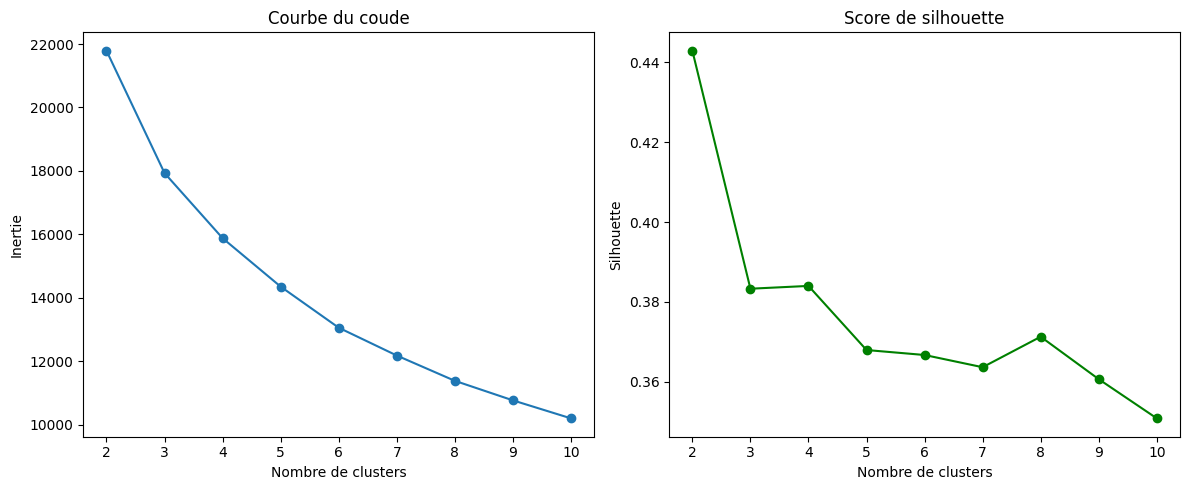


--- Répartition des clients par cluster et code_naf ---
code_naf  0111Z  0121Z  0128Z  0130Z  0143Z  0147Z  0149Z  0161Z  0162Z  \
cluster                                                                   
0             8      1      0      1      4      2      0      6      2   
1             0      0      3      0      0      4      0      0      0   
2             0      1      0     10      0      3      4      4      4   
3             0      0      1      0      0      5      0      0      0   

code_naf  0210Z  ...  9525Z  9529Z  9601B  9602A  9602B  9602a  9604Z  9609Z  \
cluster          ...                                                           
0             1  ...      0      4      6     41      6      2      5     16   
1             0  ...      0      0      0      0      0      0      0      0   
2             0  ...      5     10      4     61     23      0      3     20   
3             0  ...      0      1      2     10      4      0      0      3   

code_naf  I

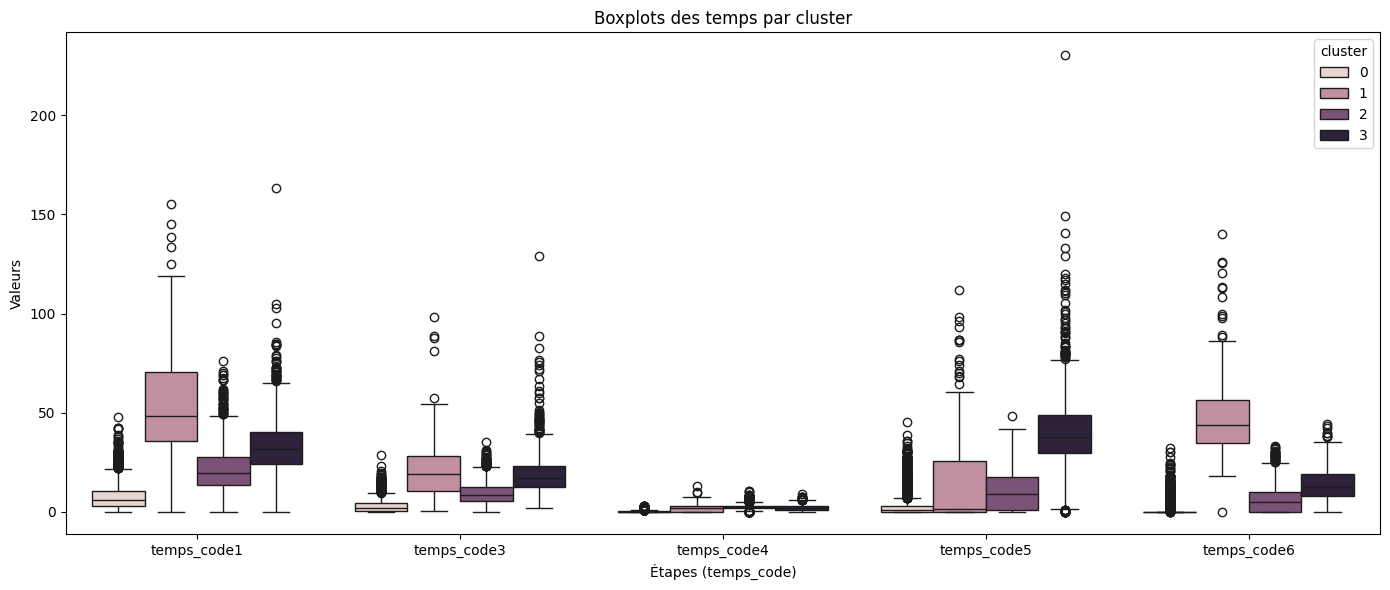


--- Clustering basé sur temps_code1 + code_naf ---
          count       mean        std    min     25%    50%      75%     max
cluster                                                                     
0         135.0  23.185259  12.689384   0.17  14.585  22.25  29.6000   64.25
1        6280.0  17.820790  15.372751   0.05   6.250  13.86  25.2750  163.20
2          20.0  33.978500  20.462463  10.05  18.375  26.27  41.7875   72.30


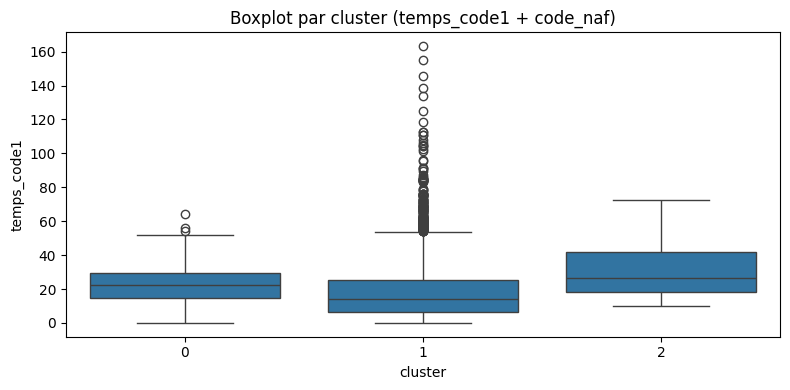


--- Clustering basé sur temps_code3 + code_naf ---
          count      mean       std   min   25%    50%     75%     max
cluster                                                               
0          84.0  3.341429  2.002402  0.15  2.09  2.915   4.690   10.21
1          55.0  6.320182  8.074800  0.10  1.15  2.700   9.375   38.55
2        6439.0  8.202518  8.790525  0.02  1.90  5.800  11.500  129.20


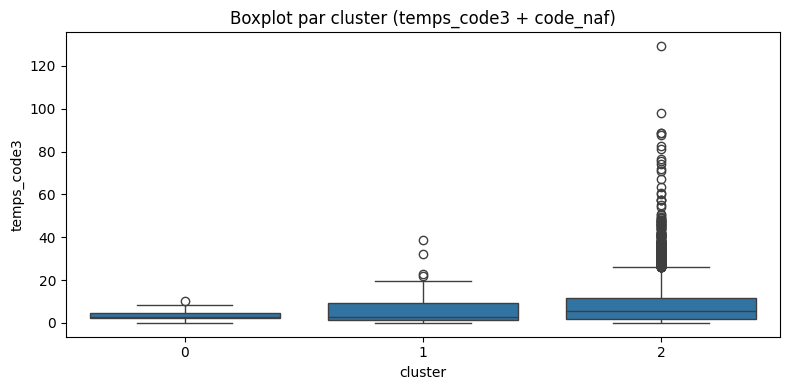


--- Clustering basé sur temps_code4 + code_naf ---
          count      mean       std   min     25%    50%     75%    max
cluster                                                                
0          18.0  3.027778  1.197942  0.30  2.3875  2.825  3.7625   5.55
1        4077.0  2.119583  1.297854  0.05  1.3500  2.050  2.7500  12.70
2          49.0  2.850612  1.327296  1.00  1.9500  2.450  3.3500   7.05


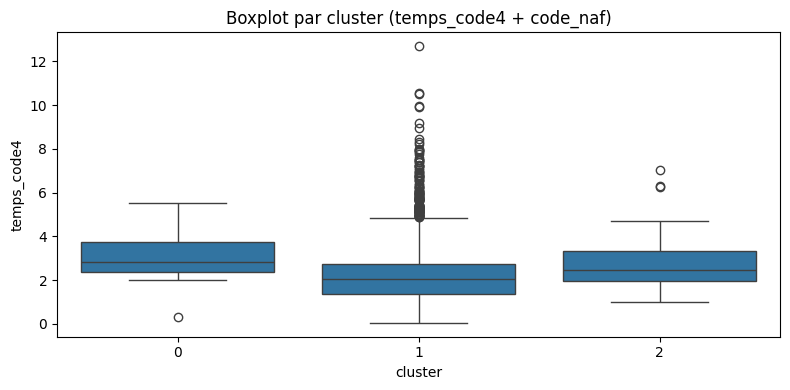


--- Clustering basé sur temps_code5 + code_naf ---
          count       mean        std   min    25%    50%    75%     max
cluster                                                                 
0          41.0  22.207073  13.652802  5.15  10.60  19.05  36.05   53.03
1          22.0   5.593636  11.976798  0.20   0.50   0.75   2.15   53.35
2        5366.0  14.430257  18.154434  0.05   1.45   7.03  21.59  230.40


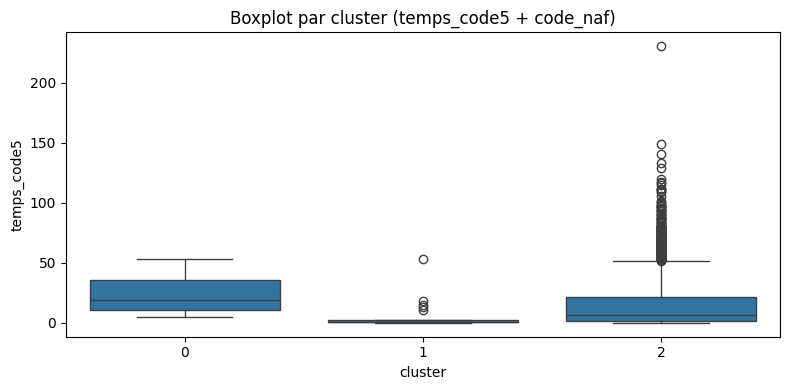

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score  # import essentiel

# --- Filtrage des colonnes temps ---
temps_cols = [col for col in data.columns if col.startswith("temps_code")]
data_filtered = data[data[temps_cols].sum(axis=1) > 0].copy()

# --- Vérification code_naf ---
if "code_naf" not in data_filtered.columns:
    raise KeyError("La colonne 'code_naf' est manquante dans le dataset.")

# --- Standardisation ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_filtered[temps_cols])

# --- Courbe du coude ---
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title("Courbe du coude")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title("Score de silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

# --- Choix du nombre de clusters ---
k_best = 4  # ou choisi selon la courbe
kmeans = KMeans(n_clusters=k_best, random_state=42)
data_filtered["cluster"] = kmeans.fit_predict(X_scaled)

# --- Matrice de répartition : cluster x code_naf ---
print("\n--- Répartition des clients par cluster et code_naf ---")
matrix = pd.crosstab(data_filtered['cluster'], data_filtered['code_naf'])
print(matrix)

# --- Boxplot des temps par cluster ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=pd.melt(data_filtered.reset_index(), id_vars="cluster", value_vars=temps_cols),
            x="variable", y="value", hue="cluster")
plt.title("Boxplots des temps par cluster")
plt.xlabel("Étapes (temps_code)")
plt.ylabel("Valeurs")
plt.tight_layout()
plt.show()

# --- Clustering successif par code_naf + 1 seule variable temps ---
def cluster_par_naf_et_temps(col_name):
    df = data_filtered[["code_naf", col_name]].dropna()
    df = df[df[col_name] > 0].copy()
    df['code_naf_str'] = df['code_naf'].astype(str)

    # Encodage simple des codes naf
    df_encoded = pd.get_dummies(df['code_naf_str'], prefix="NAF")
    X = pd.concat([df[[col_name]], df_encoded], axis=1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)

    print(f"\n--- Clustering basé sur {col_name} + code_naf ---")
    print(df.groupby('cluster')[col_name].describe())

    # Boxplot pour visualiser les clusters
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='cluster', y=col_name)
    plt.title(f"Boxplot par cluster ({col_name} + code_naf)")
    plt.tight_layout()
    plt.show()

# Appliquer pour temps_code1, 3, 4, 5
for col in ["temps_code1", "temps_code3", "temps_code4", "temps_code5"]:
    if col in data_filtered.columns:
        cluster_par_naf_et_temps(col)


###TEMPS 1


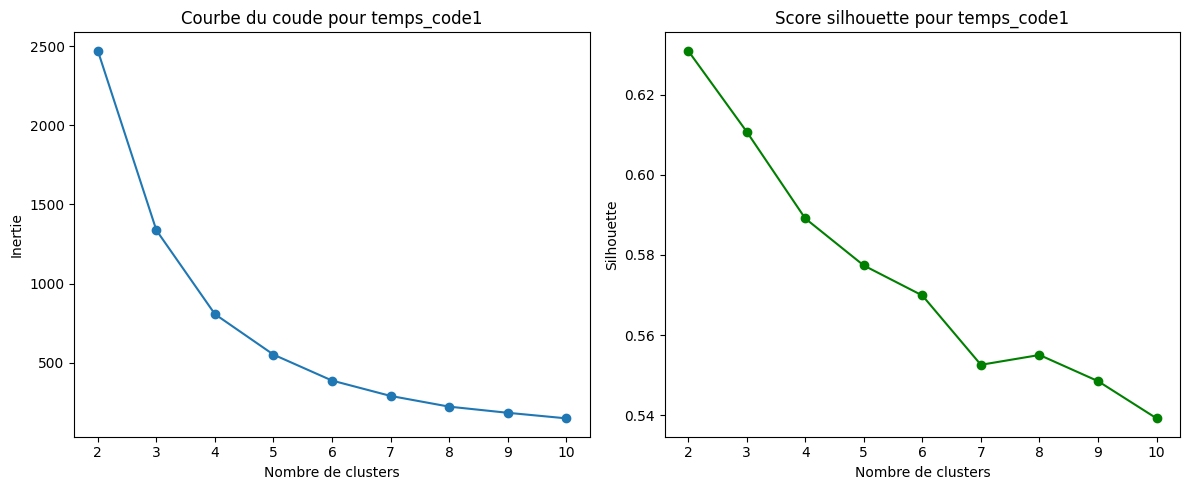


Répartition des codes NAF par cluster :
code_naf  0111Z  0121Z  0128Z  0130Z  0143Z  0147Z  0149Z  0161Z  0162Z  \
cluster                                                                   
0             0      1      1      5      0      6      0      4      0   
1             2      0      0      0      4      1      4      2      2   
2             0      0      3      0      0      2      0      0      0   
3             4      1      0      6      0      2      0      0      4   

code_naf  0240Z  ...  9522Z  9525Z  9529Z  9601B  9602A  9602B  9602a  9604Z  \
cluster          ...                                                           
0             1  ...      3      0      0      0      6      7      0      0   
1             6  ...      2      1      8      9     33      7      0      4   
2             0  ...      0      0      0      0      1      0      0      0   
3            15  ...      3      4      5      2     67     19      2      4   

code_naf  9609Z  IRPP  
clu

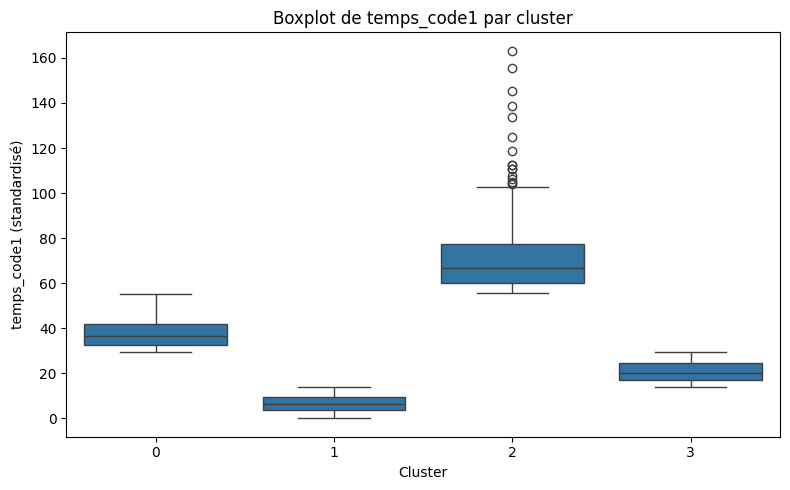

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Sélection de la variable ---
col_name = "temps_code1"

# --- Filtrage des données où temps_code1 > 0 ---
df = data[[col_name, "code_naf"]].dropna()
df = df[df[col_name] > 0].copy()

# --- Standardisation de la variable ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[[col_name]])

# --- Courbe du coude et score silhouette ---
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title(f"Courbe du coude pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title(f"Score silhouette pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

# --- Clustering avec KMeans, choisir k (par exemple 3) ---
k_best = 4
kmeans = KMeans(n_clusters=k_best, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# --- Matrice de répartition cluster x code_naf ---
print("\nRépartition des codes NAF par cluster :")
print(pd.crosstab(df['cluster'], df['code_naf']))

# --- Boxplot des temps par cluster ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='cluster', y=col_name)
plt.title(f"Boxplot de {col_name} par cluster")
plt.xlabel("Cluster")
plt.ylabel(f"{col_name} (standardisé)")
plt.tight_layout()
plt.show()


In [25]:
# Dictionnaire simplifié des codes NAF vers activités (à compléter selon ton besoin)
naf_activities = {
    "1071C": "Fabrication de pain et pâtisserie fraîche",
    "4520A": "Entretien et réparation de véhicules automobiles",
    "5610A": "Restauration traditionnelle",
    "6820B": "Location de logements",
    "6820A": "Location de biens immobiliers",
    "6420Z": "Activités des sociétés holding",
    "2222Z": "Fabrication de produits en plastique",
    "5630Z": "Débits de boissons"
    # Ajoute ici les autres codes NAF que tu as dans tes données
}

naf_counts = pd.crosstab(df['cluster'], df['code_naf'])

for cluster_id in naf_counts.index:
    print(f"\nCluster {cluster_id} - Nombre de codes NAF différents : {naf_counts.loc[cluster_id].gt(0).sum()}")
    print(f"Cluster {cluster_id} - Top codes NAF :")
    top_codes = naf_counts.loc[cluster_id].sort_values(ascending=False).head(3)
    for code, count in top_codes.items():
        activity = naf_activities.get(code, "Activité inconnue")
        print(f"  Code NAF {code} : {count} clients - {activity}")



Cluster 0 - Nombre de codes NAF différents : 160
Cluster 0 - Top codes NAF :
  Code NAF 1071C : 155 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 4520A : 73 clients - Entretien et réparation de véhicules automobiles
  Code NAF 5610A : 64 clients - Restauration traditionnelle

Cluster 1 - Nombre de codes NAF différents : 197
Cluster 1 - Top codes NAF :
  Code NAF 6820B : 1194 clients - Location de logements
  Code NAF 6820A : 227 clients - Location de biens immobiliers
  Code NAF 6420Z : 189 clients - Activités des sociétés holding

Cluster 2 - Nombre de codes NAF différents : 65
Cluster 2 - Top codes NAF :
  Code NAF 4520A : 16 clients - Entretien et réparation de véhicules automobiles
  Code NAF 1071C : 12 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 2222Z : 8 clients - Fabrication de produits en plastique

Cluster 3 - Nombre de codes NAF différents : 198
Cluster 3 - Top codes NAF :
  Code NAF 1071C : 302 clients - Fabrication de pain et pâtisserie 

#temps 3


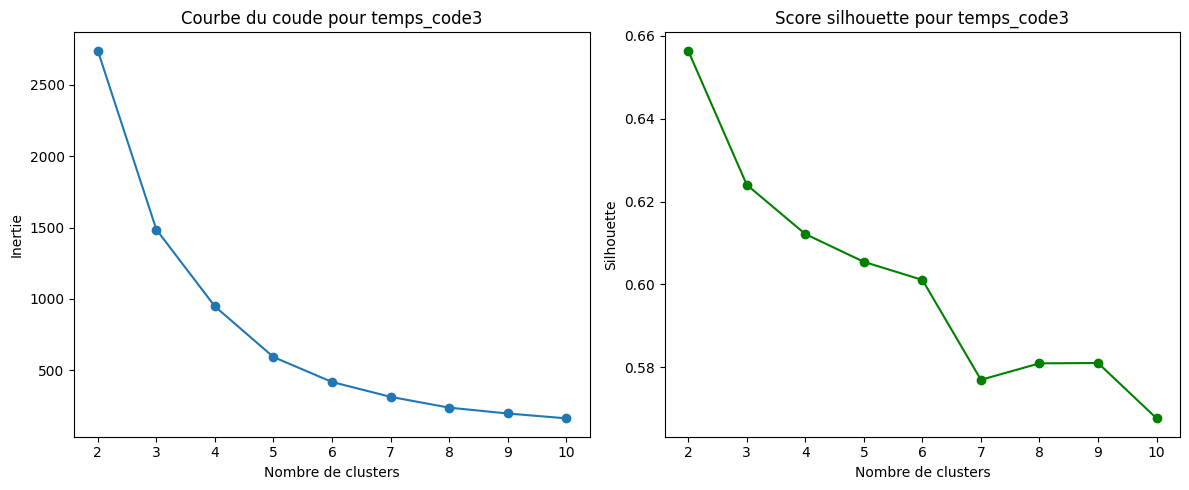


Répartition des codes NAF par cluster :
code_naf  0111Z  0121Z  0128Z  0130Z  0143Z  0147Z  0149Z  0161Z  0162Z  \
cluster                                                                   
0             8      0      0      5      4      4      2      5      5   
1             0      0      2      0      0      3      0      0      0   
2             0      2      0      6      0      6      2      4      1   
3             0      0      2      0      0      0      0      0      0   

code_naf  0210Z  ...  9525Z  9529Z  9601B  9602A  9602B  9602a  9604Z  9609Z  \
cluster          ...                                                           
0             1  ...      3      8      6     39     10      2      5     29   
1             0  ...      0      0      3     14      2      0      0      3   
2             0  ...      2      7      2     59     21      0      3      7   
3             0  ...      0      0      0      0      0      0      0      0   

code_naf  IRPP  LMNP  
clus

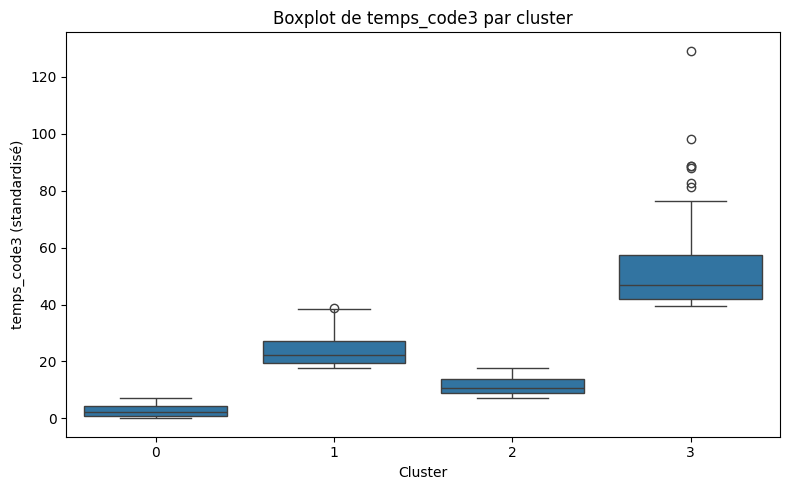

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Sélection de la variable ---
col_name = "temps_code3"

# --- Filtrage des données où temps_code1 > 0 ---
df = data[[col_name, "code_naf"]].dropna()
df = df[df[col_name] > 0].copy()

# --- Standardisation de la variable ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[[col_name]])

# --- Courbe du coude et score silhouette ---
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title(f"Courbe du coude pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title(f"Score silhouette pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

# --- Clustering avec KMeans, choisir k (par exemple 3) ---
k_best = 4
kmeans = KMeans(n_clusters=k_best, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# --- Matrice de répartition cluster x code_naf ---
print("\nRépartition des codes NAF par cluster :")
print(pd.crosstab(df['cluster'], df['code_naf']))

# --- Boxplot des temps par cluster ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='cluster', y=col_name)
plt.title(f"Boxplot de {col_name} par cluster")
plt.xlabel("Cluster")
plt.ylabel(f"{col_name} (standardisé)")
plt.tight_layout()
plt.show()


In [30]:
naf_counts = pd.crosstab(df['cluster'], df['code_naf'])

for cluster_id in naf_counts.index:
    print(f"\nCluster {cluster_id} - Nombre de codes NAF différents : {naf_counts.loc[cluster_id].gt(0).sum()}")
    print(f"Cluster {cluster_id} - Top codes NAF :")
    top_codes = naf_counts.loc[cluster_id].sort_values(ascending=False).head(3)
    for code, count in top_codes.items():
        activity = naf_activities.get(code, "Activité inconnue")
        print(f"  Code NAF {code} : {count} clients - {activity}")



Cluster 0 - Nombre de codes NAF différents : 239
Cluster 0 - Top codes NAF :
  Code NAF 6820B : 1124 clients - Location de logements
  Code NAF 6820A : 219 clients - Location de biens immobiliers
  Code NAF 6420Z : 189 clients - Activités des sociétés holding

Cluster 1 - Nombre de codes NAF différents : 132
Cluster 1 - Top codes NAF :
  Code NAF 1071C : 81 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 5610A : 62 clients - Restauration traditionnelle
  Code NAF 4520A : 26 clients - Entretien et réparation de véhicules automobiles

Cluster 2 - Nombre de codes NAF différents : 218
Cluster 2 - Top codes NAF :
  Code NAF 1071C : 305 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 5610A : 133 clients - Restauration traditionnelle
  Code NAF 5630Z : 93 clients - Débits de boissons

Cluster 3 - Nombre de codes NAF différents : 32
Cluster 3 - Top codes NAF :
  Code NAF 5610A : 8 clients - Restauration traditionnelle
  Code NAF 6910Z : 5 clients - Activité incon

Temps 4

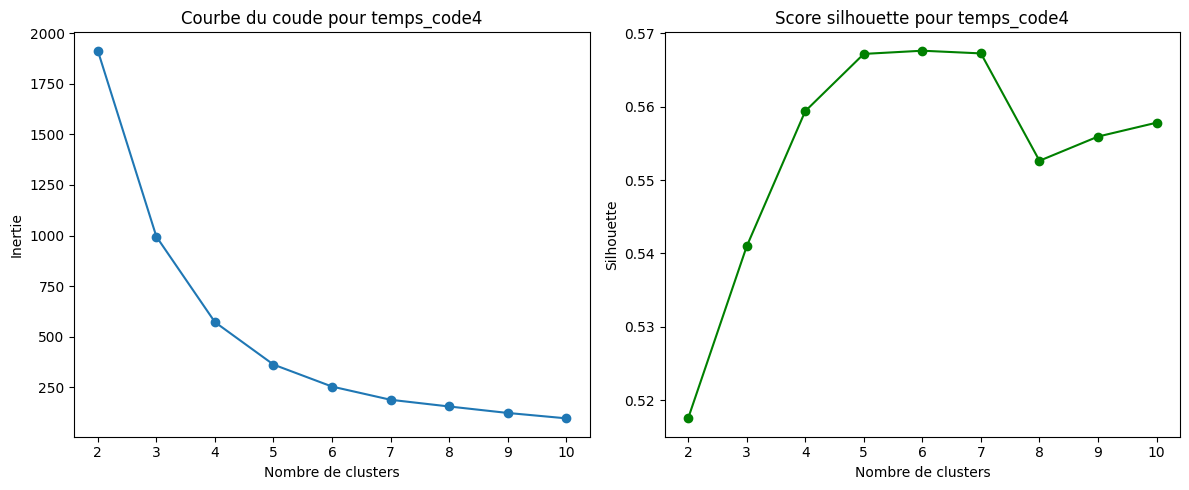


Répartition des codes NAF par cluster :
code_naf  0121Z  0128Z  0130Z  0147Z  0149Z  0161Z  0162Z  0240Z  1013B  \
cluster                                                                   
0             0      0      2      1      3      2      3      3      2   
1             1      3      2      1      0      2      1      1      0   
2             0      0      0      2      0      0      1      0      0   
3             0      1      6      3      1      2      0     16      6   

code_naf  1020Z  ...  9511Z  9522Z  9525Z  9529Z  9601B  9602A  9602B  9602a  \
cluster          ...                                                           
0             1  ...      1      2      0      5      3     20      7      0   
1             1  ...      2      3      0      1      2     10      5      1   
2             0  ...      0      0      0      1      0      1      0      0   
3             2  ...      5      2      5      5      4     41     18      0   

code_naf  9604Z  9609Z  
cl

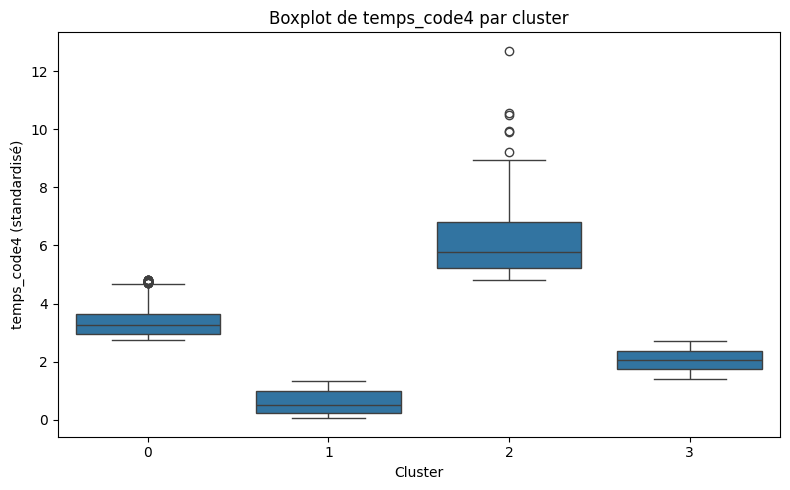

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Sélection de la variable ---
col_name = "temps_code4"

# --- Filtrage des données où temps_code1 > 0 ---
df = data[[col_name, "code_naf"]].dropna()
df = df[df[col_name] > 0].copy()

# --- Standardisation de la variable ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[[col_name]])

# --- Courbe du coude et score silhouette ---
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title(f"Courbe du coude pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title(f"Score silhouette pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

# --- Clustering avec KMeans, choisir k (par exemple 3) ---
k_best = 4
kmeans = KMeans(n_clusters=k_best, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# --- Matrice de répartition cluster x code_naf ---
print("\nRépartition des codes NAF par cluster :")
print(pd.crosstab(df['cluster'], df['code_naf']))

# --- Boxplot des temps par cluster ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='cluster', y=col_name)
plt.title(f"Boxplot de {col_name} par cluster")
plt.xlabel("Cluster")
plt.ylabel(f"{col_name} (standardisé)")
plt.tight_layout()
plt.show()


In [32]:
naf_counts = pd.crosstab(df['cluster'], df['code_naf'])

for cluster_id in naf_counts.index:
    print(f"\nCluster {cluster_id} - Nombre de codes NAF différents : {naf_counts.loc[cluster_id].gt(0).sum()}")
    print(f"Cluster {cluster_id} - Top codes NAF :")
    top_codes = naf_counts.loc[cluster_id].sort_values(ascending=False).head(3)
    for code, count in top_codes.items():
        activity = naf_activities.get(code, "Activité inconnue")
        print(f"  Code NAF {code} : {count} clients - {activity}")


Cluster 0 - Nombre de codes NAF différents : 169
Cluster 0 - Top codes NAF :
  Code NAF 1071C : 90 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 5610A : 58 clients - Restauration traditionnelle
  Code NAF 6420Z : 47 clients - Activités des sociétés holding

Cluster 1 - Nombre de codes NAF différents : 161
Cluster 1 - Top codes NAF :
  Code NAF 6820B : 353 clients - Location de logements
  Code NAF 1071C : 51 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 6420Z : 48 clients - Activités des sociétés holding

Cluster 2 - Nombre de codes NAF différents : 71
Cluster 2 - Top codes NAF :
  Code NAF 1071C : 15 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 7022Z : 8 clients - Activité inconnue
  Code NAF 6420Z : 7 clients - Activités des sociétés holding

Cluster 3 - Nombre de codes NAF différents : 201
Cluster 3 - Top codes NAF :
  Code NAF 1071C : 232 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 5610A : 128 clients - Restaur

Temps 5

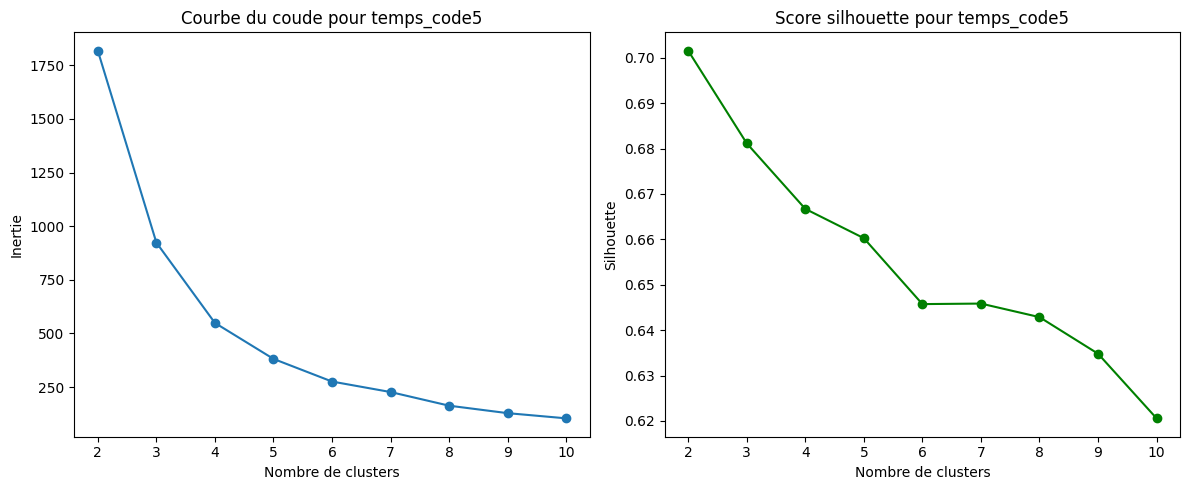


Répartition des codes NAF par cluster :
code_naf  0111Z  0128Z  0130Z  0143Z  0147Z  0149Z  0161Z  0162Z  0240Z  \
cluster                                                                   
0             0      3      0      0      2      0      0      0      3   
1             0      1      0      0      0      0      0      0      0   
2             4      0      3      3      6      4      4      4     13   
3             0      0      4      1      2      0      0      0      7   

code_naf  1013B  ...  9512Z  9522Z  9525Z  9529Z  9601B  9602A  9602B  9602a  \
cluster          ...                                                           
0             1  ...      0      0      0      1      1      4      1      0   
1             0  ...      0      0      0      0      1      0      0      0   
2             1  ...      2      2      1      7      6     67     11      2   
3            10  ...      1      5      4      3      2     29     21      0   

code_naf  9604Z  9609Z  
cl

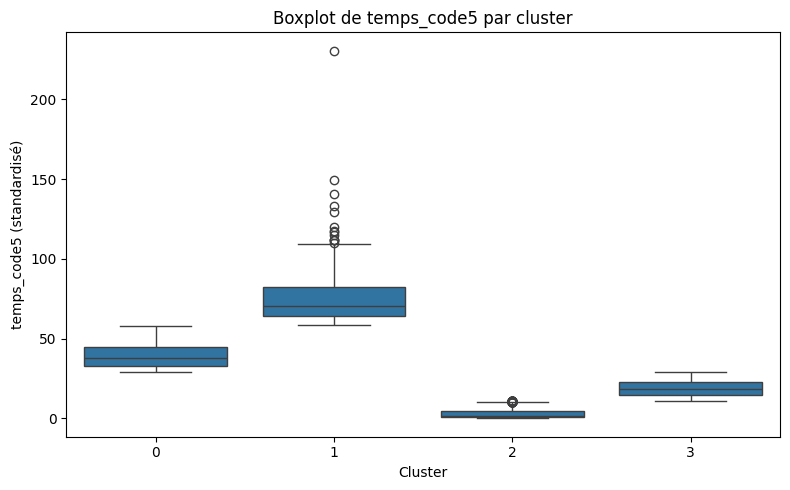

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Sélection de la variable ---
col_name = "temps_code5"

# --- Filtrage des données où temps_code1 > 0 ---
df = data[[col_name, "code_naf"]].dropna()
df = df[df[col_name] > 0].copy()

# --- Standardisation de la variable ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[[col_name]])

# --- Courbe du coude et score silhouette ---
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title(f"Courbe du coude pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title(f"Score silhouette pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

# --- Clustering avec KMeans, choisir k (par exemple 3) ---
k_best = 4
kmeans = KMeans(n_clusters=k_best, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# --- Matrice de répartition cluster x code_naf ---
print("\nRépartition des codes NAF par cluster :")
print(pd.crosstab(df['cluster'], df['code_naf']))

# --- Boxplot des temps par cluster ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='cluster', y=col_name)
plt.title(f"Boxplot de {col_name} par cluster")
plt.xlabel("Cluster")
plt.ylabel(f"{col_name} (standardisé)")
plt.tight_layout()
plt.show()


In [34]:
naf_counts = pd.crosstab(df['cluster'], df['code_naf'])

for cluster_id in naf_counts.index:
    print(f"\nCluster {cluster_id} - Nombre de codes NAF différents : {naf_counts.loc[cluster_id].gt(0).sum()}")
    print(f"Cluster {cluster_id} - Top codes NAF :")
    top_codes = naf_counts.loc[cluster_id].sort_values(ascending=False).head(3)
    for code, count in top_codes.items():
        activity = naf_activities.get(code, "Activité inconnue")
        print(f"  Code NAF {code} : {count} clients - {activity}")


Cluster 0 - Nombre de codes NAF différents : 116
Cluster 0 - Top codes NAF :
  Code NAF 1071C : 178 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 5610A : 76 clients - Restauration traditionnelle
  Code NAF 5630Z : 55 clients - Débits de boissons

Cluster 1 - Nombre de codes NAF différents : 52
Cluster 1 - Top codes NAF :
  Code NAF 1071C : 22 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 4520A : 16 clients - Entretien et réparation de véhicules automobiles
  Code NAF 5610A : 14 clients - Restauration traditionnelle

Cluster 2 - Nombre de codes NAF différents : 217
Cluster 2 - Top codes NAF :
  Code NAF 6820B : 951 clients - Location de logements
  Code NAF 6820A : 189 clients - Location de biens immobiliers
  Code NAF 6420Z : 170 clients - Activités des sociétés holding

Cluster 3 - Nombre de codes NAF différents : 160
Cluster 3 - Top codes NAF :
  Code NAF 1071C : 251 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 5610A : 114 clients 

Temps 6

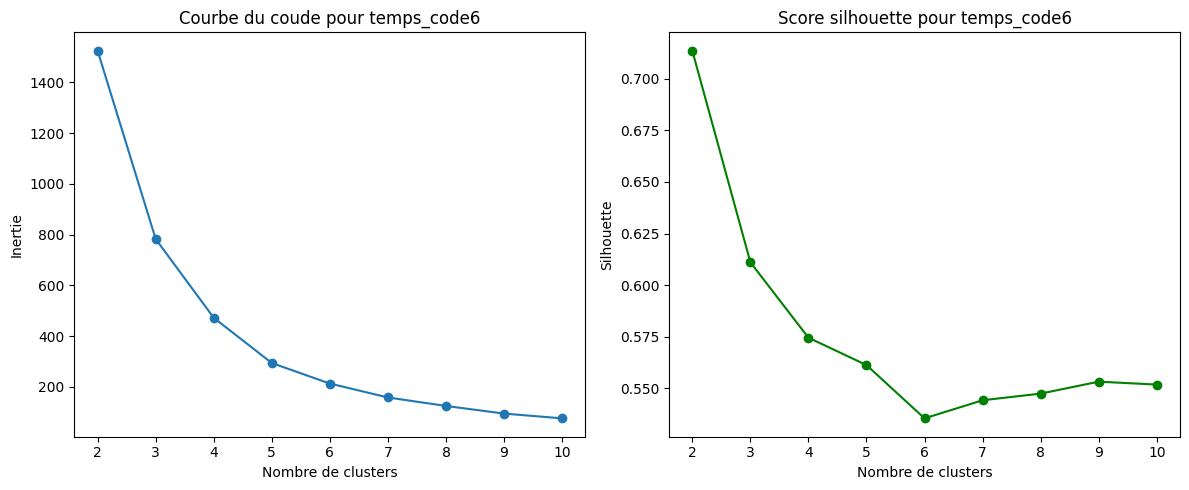


Répartition des codes NAF par cluster :
code_naf  0111Z  0128Z  0130Z  0147Z  0149Z  0161Z  0162Z  0240Z  1013B  \
cluster                                                                   
0             1      0      5      6      1      1      4     13     11   
1             0      1      5      4      0      0      1      2      1   
2             0      0      0      3      0      0      0      0      0   
3             0      3      0      1      0      0      0      0      0   

code_naf  1020Z  ...  9499Z  9511Z  9522Z  9525Z  9529Z  9601B  9602A  9602B  \
cluster          ...                                                           
0             4  ...      6      8      3      5      1      3     58     17   
1             0  ...      2      0      5      0      1      3     26      5   
2             0  ...      0      0      0      0      0      0      0      0   
3             0  ...      1      0      0      0      0      0      3      2   

code_naf  9604Z  9609Z  
cl

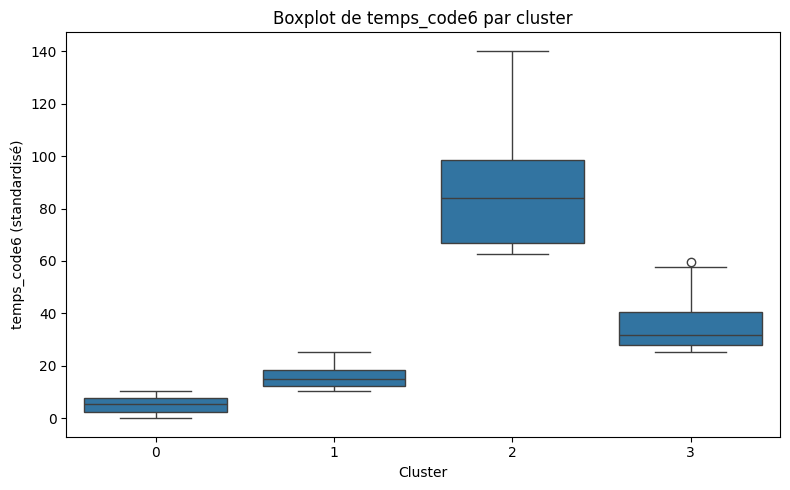

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Sélection de la variable ---
col_name = "temps_code6"

# --- Filtrage des données où temps_code1 > 0 ---
df = data[[col_name, "code_naf"]].dropna()
df = df[df[col_name] > 0].copy()

# --- Standardisation de la variable ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[[col_name]])

# --- Courbe du coude et score silhouette ---
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title(f"Courbe du coude pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title(f"Score silhouette pour {col_name}")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

# --- Clustering avec KMeans, choisir k (par exemple 3) ---
k_best = 4
kmeans = KMeans(n_clusters=k_best, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# --- Matrice de répartition cluster x code_naf ---
print("\nRépartition des codes NAF par cluster :")
print(pd.crosstab(df['cluster'], df['code_naf']))

# --- Boxplot des temps par cluster ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='cluster', y=col_name)
plt.title(f"Boxplot de {col_name} par cluster")
plt.xlabel("Cluster")
plt.ylabel(f"{col_name} (standardisé)")
plt.tight_layout()
plt.show()


In [37]:
naf_counts = pd.crosstab(df['cluster'], df['code_naf'])

for cluster_id in naf_counts.index:
    print(f"\nCluster {cluster_id} - Nombre de codes NAF différents : {naf_counts.loc[cluster_id].gt(0).sum()}")
    print(f"Cluster {cluster_id} - Top codes NAF :")
    top_codes = naf_counts.loc[cluster_id].sort_values(ascending=False).head(3)
    for code, count in top_codes.items():
        activity = naf_activities.get(code, "Activité inconnue")
        print(f"  Code NAF {code} : {count} clients - {activity}")


Cluster 0 - Nombre de codes NAF différents : 201
Cluster 0 - Top codes NAF :
  Code NAF 1071C : 228 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 5610A : 152 clients - Restauration traditionnelle
  Code NAF 5630Z : 76 clients - Débits de boissons

Cluster 1 - Nombre de codes NAF différents : 151
Cluster 1 - Top codes NAF :
  Code NAF 1071C : 246 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 5610A : 78 clients - Restauration traditionnelle
  Code NAF 4520A : 67 clients - Entretien et réparation de véhicules automobiles

Cluster 2 - Nombre de codes NAF différents : 16
Cluster 2 - Top codes NAF :
  Code NAF 2222Z : 5 clients - Fabrication de produits en plastique
  Code NAF 8621Z : 4 clients - Activité inconnue
  Code NAF 5223Z : 4 clients - Activité inconnue

Cluster 3 - Nombre de codes NAF différents : 68
Cluster 3 - Top codes NAF :
  Code NAF 1071C : 63 clients - Fabrication de pain et pâtisserie fraîche
  Code NAF 5610A : 15 clients - Restauration tr

In [45]:
temps_cols = ["temps_code1", "temps_code3", "temps_code4", "temps_code5", "temps_code6"]

def get_medians_and_clusters_for_code_naf(code_naf, dict_df, medians_dict):
    """
    Pour un code NAF donné, retourne pour chaque temps :
      - le cluster auquel il appartient
      - la médiane du temps dans ce cluster
    
    Retourne un dict temps -> dict { 'cluster': int, 'mediane': float }
    """
    results = {}
    for col_name in temps_cols:
        df = dict_df[col_name]
        
        # Trouver les lignes du code NAF dans ce temps
        df_code = df[df['code_naf'] == code_naf]
        if df_code.empty:
            results[col_name] = {'cluster': None, 'mediane': None}
            continue
        
        # Cluster majoritaire pour ce code NAF
        cluster = df_code['cluster'].mode()[0]
        
        # Médiane dans ce cluster
        median_val = medians_dict[col_name].get(cluster, None)
        
        results[col_name] = {'cluster': cluster, 'mediane': median_val}
    
    return results


# Exemple d’utilisation
code_naf_query = '0240Z'
resultats = get_medians_and_clusters_for_code_naf(code_naf_query, dict_df, medians_dict)

print(f"Clusters et médianes par temps pour le code NAF {code_naf_query} :")
for temps, vals in resultats.items():
    print(f"  {temps} : Cluster = {vals['cluster']}, Médiane = {vals['mediane']}")


Clusters et médianes par temps pour le code NAF 0240Z :
  temps_code1 : Cluster = 3, Médiane = 20.35
  temps_code3 : Cluster = 2, Médiane = 10.8
  temps_code4 : Cluster = 3, Médiane = 2.05
  temps_code5 : Cluster = 2, Médiane = 1.83
  temps_code6 : Cluster = 0, Médiane = 5.455


In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Colonnes de temps à traiter ---
temps_cols = ["temps_code1", "temps_code3", "temps_code4", "temps_code5", "temps_code6"]

# Dictionnaires pour stocker résultats
all_results = []

# --- Boucle sur chaque variable de temps ---
for col_name in temps_cols:
    print(f"Traitement de {col_name}...")

    # --- Préparer les données ---
    df = data[[col_name, "code_naf"]].dropna()
    df = df[df[col_name] > 0].copy()
    df = df.reset_index(drop=True)

    # --- Clustering ---
    X_scaled = StandardScaler().fit_transform(df[[col_name]])
    kmeans = KMeans(n_clusters=4, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)

    # --- Calcul de la médiane par cluster ---
    medians = df.groupby('cluster')[col_name].median().to_dict()

    # --- Attribution du cluster majoritaire par code_naf ---
    naf_clusters = (
        df.groupby(['code_naf', 'cluster'])
        .size()
        .reset_index(name='count')
        .sort_values(['code_naf', 'count'], ascending=[True, False])
        .drop_duplicates('code_naf')
    )

    # --- Ajout de la médiane du cluster correspondant ---
    naf_clusters['mediane'] = naf_clusters['cluster'].map(medians)
    naf_clusters['temps_code'] = col_name

    # --- Sélection des colonnes et ajout au résultat ---
    all_results.append(naf_clusters[['code_naf', 'temps_code', 'cluster', 'mediane']])

# --- Fusion de tous les résultats ---
final_df = pd.concat(all_results, ignore_index=True)

# --- Sauvegarde dans un CSV ---
final_df.to_csv("datanaf.csv", index=False)

print("✅ Fichier datanaf.csv créé avec succès.")


Traitement de temps_code1...
Traitement de temps_code3...
Traitement de temps_code4...
Traitement de temps_code5...
Traitement de temps_code6...
✅ Fichier datanaf.csv créé avec succès.


In [48]:
df = pd.read_csv("datanaf.csv")

# Afficher les 10 premières lignes
print(df.head(10))

  code_naf   temps_code  cluster  mediane
0    0111Z  temps_code1        3   20.350
1    0121Z  temps_code1        0   36.400
2    0128Z  temps_code1        2   66.905
3    0130Z  temps_code1        3   20.350
4    0143Z  temps_code1        1    6.250
5    0147Z  temps_code1        0   36.400
6    0149Z  temps_code1        1    6.250
7    0161Z  temps_code1        0   36.400
8    0162Z  temps_code1        3   20.350
9    0240Z  temps_code1        3   20.350


In [50]:
results = []

for temps_code, df in dict_df.items():
    # Calculer stats par cluster sur la bonne colonne temps_codeX
    stats = df.groupby('cluster')[temps_code].agg(
        mediane='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75),
        etendue=lambda x: x.max() - x.min()
    ).reset_index()
    
    # Merge avec la liste des code_naf + cluster
    merged = df[['code_naf', 'cluster']].drop_duplicates().merge(stats, on='cluster')
    merged['temps_code'] = temps_code
    results.append(merged)

final_df = pd.concat(results, ignore_index=True)

final_df.to_csv("datanaf.csv", index=False)



In [52]:
df = pd.read_csv("datanaf.csv")

# Afficher les 10 premières lignes
print(df.head(1000))

    code_naf  cluster  mediane     q1     q3  etendue   temps_code
0      4511Z        1     6.25   3.85   9.60    13.70  temps_code1
1      0161Z        1     6.25   3.85   9.60    13.70  temps_code1
2      5630Z        3    20.35  16.98  24.43    15.54  temps_code1
3      1071C        3    20.35  16.98  24.43    15.54  temps_code1
4      4321A        1     6.25   3.85   9.60    13.70  temps_code1
..       ...      ...      ...    ...    ...      ...          ...
995    7500Z        0     2.33   0.90   4.40     7.03  temps_code3
996    1072Z        2    10.80   8.85  13.71    10.61  temps_code3
997    8621Z        1    22.17  19.52  27.18    21.06  temps_code3
998    2511Z        2    10.80   8.85  13.71    10.61  temps_code3
999    4634Z        2    10.80   8.85  13.71    10.61  temps_code3

[1000 rows x 7 columns]
